In [34]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [35]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from importlib import reload


In [36]:
def get_most_recent_output_folder_name():
    most_recent_output_folder_name = sorted(glob.glob("./runs/*"))[-1]
    return most_recent_output_folder_name


most_recent_output_folder_name = get_most_recent_output_folder_name()
time_series = pickle.load(
    open(most_recent_output_folder_name + "/time_series.pickle", "rb")
)


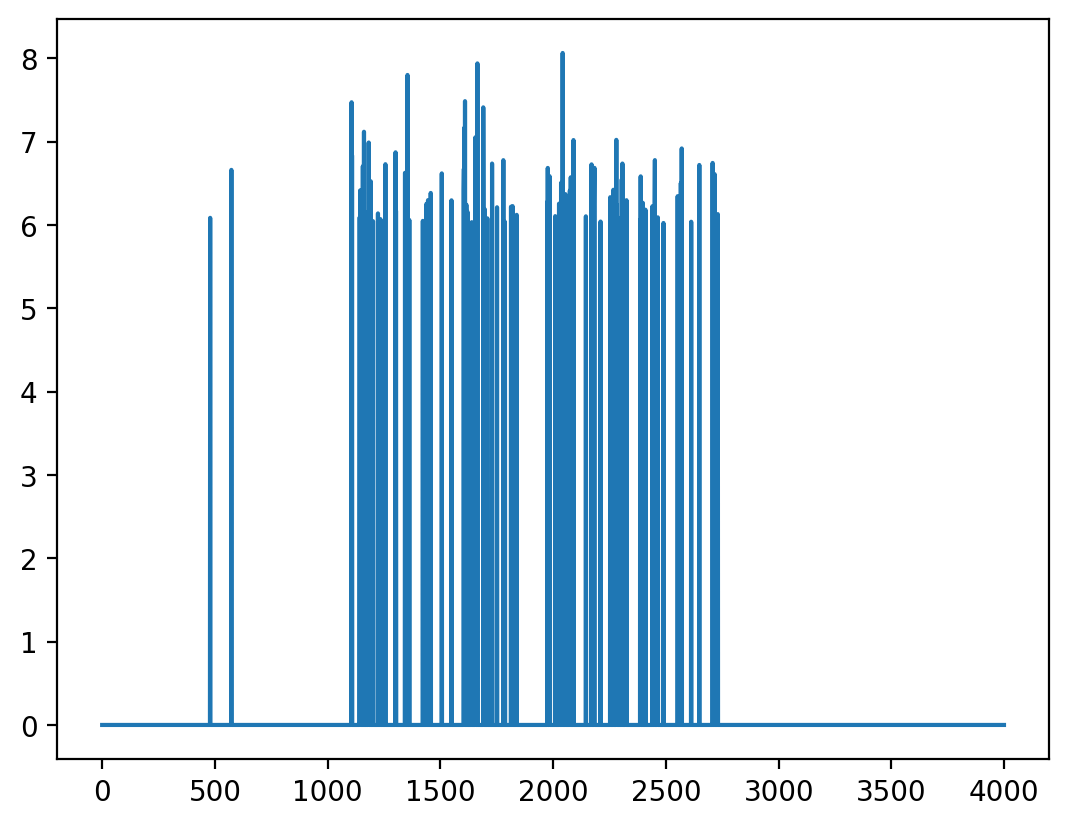

In [37]:
plt.plot(time_series.event_magnitude)